In [89]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, Sequential
from keras import optimizers
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
import scipy

In [169]:
#set epochs, batch size
num_epochs = 1
batches = 16

#set directories
workDir = "/Users/michaelcarrigan/Desktop/DisTracks/autoencoder/"
saveDir = workDir
dataDir = "/Users/michaelcarrigan/Desktop/DisTracks/data/"

#load data
data_e = np.load(dataDir+ "e_DYJets50_v4_norm_40x40.npy")
data_bkg = np.load(dataDir + "bkg_DYJets50_v4_norm_40x40.npy")
#save 20% of data for testing
test_index_e = int(len(data_e)/5)
test_index_bkg = int(len(data_bkg)/5)

#shuffle e and bkg data
indicies = np.arange(len(data_e))
np.random.shuffle(indicies)
data_e = data_e[indicies]
indicies = np.arange(len(data_bkg))
np.random.shuffle(indicies)
data_bkg = data_bkg[indicies]

#test data
test_e = data_e[:test_index_e]
test_bkg = data_e[:test_index_bkg]

data = np.concatenate([data_e[test_index_e:], data_bkg[test_index_bkg:]])
classes = np.concatenate([np.ones(len(data_e[test_index_e:])), np.zeros(len(data_bkg[test_index_bkg:]))])
print(len(data_e), len(data_bkg))

#shuffle data
indicies = np.arange(data.shape[0])
np.random.shuffle(indicies)
data = data[indicies]
classes = classes[indicies]
print(data.shape[0], "Number of samples")
print(np.shape(data))

x_train, x_val, y_train, y_val = train_test_split(data, classes, test_size=0.15, random_state=0)


(22682, 5528)
(5528, 22682)
(22569, 'Number of samples')
(22569, 40, 40, 5)


In [179]:
autoencoder = Sequential()
autoencoder.add(Dense(512,  activation='elu', input_shape=(40,40,5)))
autoencoder.add(Dense(128,  activation='elu'))
autoencoder.add(Dense(10,    activation='linear', name="bottleneck"))
autoencoder.add(Dense(128,  activation='elu'))
autoencoder.add(Dense(512,  activation='elu'))
autoencoder.add(Dense(5,  activation='sigmoid'))
autoencoder.compile(loss='mean_squared_error', optimizer = Adam())
trained_model = autoencoder.fit(x_train, x_train, batch_size=batches, epochs=num_epochs, verbose=1, validation_data=(x_val, x_val))
encoder = Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)
encoded_data = encoder.predict(x_train)  # bottleneck representation
decoded_output = autoencoder.predict(x_train)        # reconstruction
encoding_dim = 10

Train on 18055 samples, validate on 4514 samples
Epoch 1/1
18055/18055 [==============================] - 492s 27ms/step - loss: 0.0024 - val_loss: 8.6930e-04


In [181]:
# return the decoder
encoded_input = Input(shape=(encoding_dim,))
decoder = autoencoder.layers[-3](encoded_input)
decoder = autoencoder.layers[-2](decoder)
decoder = autoencoder.layers[-1](decoder)
decoder = Model(encoded_input, decoder)
print("good")

good


In [ ]:
def RecoErr(img):
    input_img = img.reshape(1, 40, 40, 5)
    pred = autoencoder.predict(input_img)
    img_flat = img.reshape(1600, 5)
    pred_flat = pred.reshape(1600, 5)
    err = np.zeros(5)
    for i in range(5):
        err[i] = np.linalg.norm(img_flat[:, i] - pred_flat[:, i], axis=-1)
    return err

In [183]:
e_ecal_err = []
e_ecalS_err = []
e_hcal_err = []
e_muons_err = []
e_err = [e_ecal_err, e_ecalS_err, e_hcal_err, e_muons_err]
bkg_ecal_err = []
bkg_ecalS_err = []
bkg_hcal_err = []
bkg_muons_err = []
bkg_err = [bkg_ecal_err, bkg_ecalS_err, bkg_hcal_err, bkg_muons_err]
e_indicies = np.arange(int(test_e.shape[0]/2))
bkg_indicies = np.arange(int(test_bkg.shape[0]/2))
trials_e = np.random.choice(e_indicies, size=(500))
trials_bkg = np.random.choice(bkg_indicies, size=(500))
for i in range(500):
    this_e_err = RecoErr(test_e[trials_e[i]])
    this_bkg_err = RecoErr(test_bkg[trials_bkg[i]])
    for j in range(4):
        e_err[j].append(this_e_err[j+1])
        bkg_err[j].append(this_bkg_err[j+1])

print("done again")

done again


Text(0.5,1,'Muons Background')

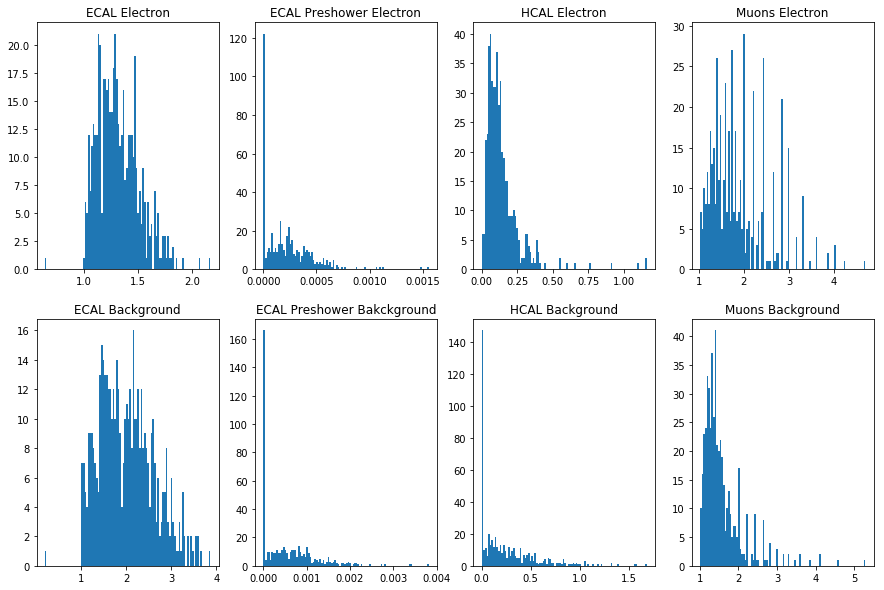

In [160]:
num_bins = 100
fig, my_plt = plt.subplots(2, 4, figsize=(15,10))
my_plt[0,0].hist(e_err[0], bins=num_bins)
my_plt[0,0].set_title("ECAL Electron")
my_plt[0,1].hist(e_err[1], bins = num_bins)
my_plt[0,1].set_title("ECAL Preshower Electron")
my_plt[0,2].hist(e_err[2], bins = num_bins)
my_plt[0,2].set_title("HCAL Electron")
my_plt[0,3].hist(e_err[3], bins = num_bins)
my_plt[0,3].set_title("Muons Electron")
my_plt[1,0].hist(bkg_err[0], bins=num_bins)
my_plt[1,0].set_title("ECAL Background")
my_plt[1,1].hist(bkg_err[1], bins = num_bins)
my_plt[1,1].set_title("ECAL Preshower Bakckground")
my_plt[1,2].hist(bkg_err[2], bins = num_bins)
my_plt[1,2].set_title("HCAL Background")
my_plt[1,3].hist(bkg_err[3], bins = num_bins)
my_plt[1,3].set_title("Muons Background")

(1.5644503936211085, 0.3638789963791272)
[2.42429207e-01 2.09532136e-04 9.09375116e-02 8.08335892e-01]
[1.33606480e+00 2.14969454e-04 1.33277660e-01 2.02670875e+00]
fine


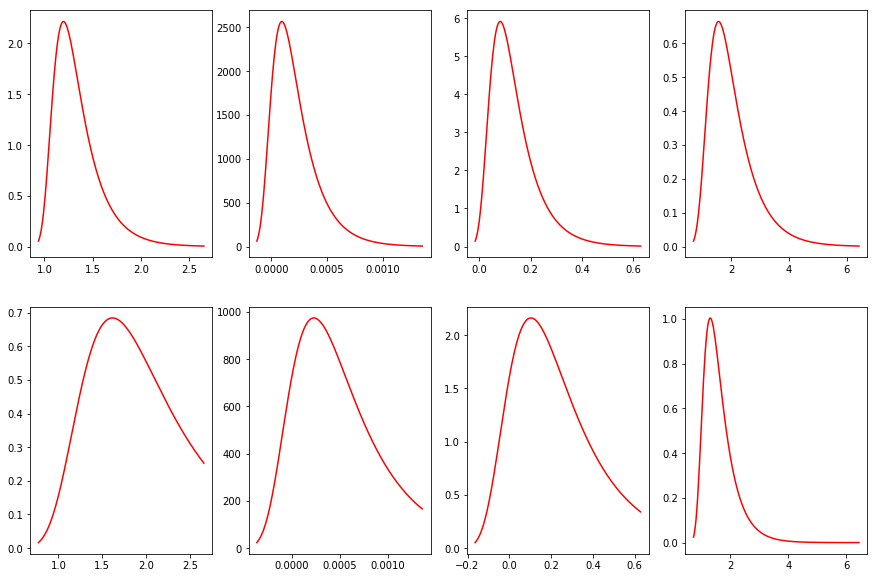

In [143]:
std_e = np.zeros(4)
std_bkg = np.zeros(4)
mean_e = np.zeros(4)
mean_bkg = np.zeros(4)

fig2, ax = plt.subplots(2,4, figsize = (15,10))

for i in range(4):
    fit_e = scipy.stats.moyal.fit(e_err[i])
    fit_bkg = scipy.stats.moyal.fit(bkg_err[i])
    moy = scipy.stats.moyal(fit_e[0], fit_e[1])
    moy_bkg = scipy.stats.moyal(fit_bkg[0], fit_bkg[1])
    x = np.linspace(moy.ppf(0.001), moy.ppf(0.999), 200)
    x_bkg = np.linspace(moy_bkg.ppf(0.001), moy.ppf(0.999), 200)
    ax[0,i].plot(x, moy.pdf(x), color="red")
    ax[1,i].plot(x_bkg, moy_bkg.pdf(x_bkg), color="red")
    std_e[i] = moy.std()
    std_bkg[i] = moy_bkg.std()
    mean_e[i] = moy.mean()
    mean_bkg[i] = moy_bkg.mean()

print(fit_e) 
print(std_e)
print(mean_e)
#m_ecal = scipy.stats.moyal(fit_e[0])
#my_plt[0,0].plot(m_ecal, color="red")
print("fine")

In [176]:
def testImg(img):
    err = RecoErr(img)
    this_std_e = abs(err[1:] - mean_e) / std_e
    this_std_bkg = abs(err[1:] - mean_bkg) / std_bkg
    sim_count = 0
    is_e = False
    small_std = 10e6
    for i in range(4):
        #if(this_std_e[i] < this_std_bkg[i]): sim_count +=1
        #else: sim_count += -1
        if(this_std_e[i] < small_std): 
            small_std = this_std_e[i]
            is_e = True
        if(this_std_bkg[i] < small_std):
            small_std = this_std_bkg[i]
            is_e = False
    #if(sim_count >= 0): is_e = True
    #if(sim_count == 0): return this_std_e, this_std_bkg
    #if(sim_count < 0): is_e = False
    return this_std_e, this_std_bkg, is_e

In [177]:
num_e_test = int(len(test_e)/2)
num_bkg_test = int(len(test_bkg)/2)
e_evts = 0
bkg_evts = 0
for i in range(num_e_test):
    e_std, bkg_std, is_e = testImg(test_e[num_e_test+i])
    #print(e_std, bkg_std, is_e)
    if(is_e == True): e_evts += 1
    else: bkg_evts += 1
print(e_evts, bkg_evts)
e_evts = 0
bkg_evts = 0
for i in range(num_bkg_test):
    e_std, bkg_std, is_e = testImg(test_bkg[num_bkg_test+i])
    if(is_e == True): e_evts += 1
    else: bkg_evts += 1
print(e_evts, bkg_evts)


(353, 199)
(1421, 847)
